# Model training
In diesem Notebook trainieren wir ein Neuronales Netz auf den Trainingsdaten, welche wir im Schritt [Objektextraktion](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-objektextraktion) erstellt haben. Die Daten sollten in einer sog. Baumstruktur angeordnet sein: Wir brauchen ein Verzeichnis für jede Klasse, und darin alle Bilder dieser Klasse.

Zunächst müssen wir unsere Objektbilder finden. Dies sind Bilder mit einer engen *Bounding Box* um das Objekt herum: 

In der nächsten Zelle extrahieren wir die Klasse aus dem Dateinamen des Bildes

In [423]:
#Import Libraries
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import scikitplot as skplt # last update: 2018
import os,datetime

In [424]:
# Testing-Cockpit
training_size=0.7 #Ursprünglich 0.6
validation_size=0.2
batch_size=16 #Ursprünglich 32
image_size=(128,128) #Ursprünglich 64,64 
filter_size=(3,3,3)
filter_amount=(16,32,64)
dense=64 #Ursprünglich 128

In [425]:
files = [f for f in Path('../02_Alle_Gipfel').glob('*')]
s = files[0].name
idx = s.find('_')
Klassenliste = []
filenameliste = [fn for fn in Path('../02_Alle_Gipfel').glob('*')]
for filename in filenameliste:
    idx=filename.name.find('_')
    klasse = filename.name[:idx]
    Klassenliste.append(klasse)
len(Klassenliste)
Klassennamen = np.unique(Klassenliste).tolist()

In [426]:
# 60% Aller Daten werden als Trainingsdaten verwendet
Anzahl_Trainingsbeispiele = np.floor(pd.Series(Klassenliste).value_counts()*training_size).astype('int') #TODO:
Anzahl_Trainingsbeispiele

Keimkraft       45
Laugengipfel    42
Buttergipfel    33
.DS              0
Name: count, dtype: int64

Nun erstellen wir die Baumstruktur, und zwar unter dem folgenden Pfad (nicht in allen Pfaden lassen sich Unterverzeichnisse erstellen!):

In [427]:
Baumstrukturpfad = './'
Baumstrukturpfad=Path(Baumstrukturpfad)
(Baumstrukturpfad/'train').mkdir(parents=True,exist_ok=True) #Ablageort der Trainingsdaten
(Baumstrukturpfad/'test').mkdir(parents=True,exist_ok=True) #Ablageort der Testdaten
for klasse in Klassennamen:
    pfad_train = (Baumstrukturpfad/'train'/klasse)
    pfad_test = (Baumstrukturpfad/'test'/klasse)

    pfad_train.mkdir(parents=True,exist_ok=True)
    pfad_test.mkdir(parents=True,exist_ok=True)

[DefaultDict-Dictionaries](https://www.python-kurs.eu/python3_dictionaries.php) sind im folgenden nützlich. [Dieses Video](https://ingo-janssen.de/python-erweiterte-datentypen-was-ist-defaultdict/) gibt eine gute Einführung.

In [428]:
already_copied=defaultdict(lambda :0) #defaultdict's sind Dictionaries mit einem Default-Returnwert, hier 0 
already_copied['noch nicht existierender Key']

0

Wir bauen damit nun eine if/else-Klausel, so dass die in `Anzahl_Trainingsbeispiele` angegebene Anzahl Dateien als Trainingsdaten verwendet  (in das Unterverzeichnis 'train' kopiert) werden, und der Rest als Testdaten verwendet werden.

In [429]:

train_or_test=dict()
i=0
for ifile,(filename,klasse) in enumerate(zip(filenameliste,Klassenliste)):
    if ifile<6: #einfach, um ein paar Erklärungen zu erhalten, aber nicht zu viele
        print('kopiere',filename,'nach',Baumstrukturpfad/klasse/filename.name)
    elif ifile==6:
        print('...')
    if already_copied[klasse]<Anzahl_Trainingsbeispiele[klasse]:
        shutil.copyfile(filename,Baumstrukturpfad/'train'/klasse/filename.name)
        already_copied[klasse]+=1 # zähle mit, wieviele Beispiele schon in das Verzeichnis 'train' kopiert wurden.
        train_or_test[filename.name]='train'
    else:
        shutil.copyfile(filename,Baumstrukturpfad/'test'/klasse/filename.name)
        train_or_test[filename.name]='test'
    
print('Done.')


kopiere ../02_Alle_Gipfel/Laugengipfel_low_light_34.jpg nach Laugengipfel/Laugengipfel_low_light_34.jpg
kopiere ../02_Alle_Gipfel/Laugengipfel_low_light_20.jpg nach Laugengipfel/Laugengipfel_low_light_20.jpg
kopiere ../02_Alle_Gipfel/Keimkraft_Gipfel_light_15.jpg nach Keimkraft/Keimkraft_Gipfel_light_15.jpg
kopiere ../02_Alle_Gipfel/Laugengipfel_light_19.jpg nach Laugengipfel/Laugengipfel_light_19.jpg
kopiere ../02_Alle_Gipfel/Keimkraft_Gipfel_light_01.jpg nach Keimkraft/Keimkraft_Gipfel_light_01.jpg
kopiere ../02_Alle_Gipfel/Keimkraft_Gipfel_light_29.jpg nach Keimkraft/Keimkraft_Gipfel_light_29.jpg
...
Done.


Überprüfen wir, dass die Bilder an die richtige Stelle kopiert wurden!

Wir sollten im Folgenden *nur noch Trainingsbeispiele zum Training des neuronalen Netzes verwenden*. Die Testbeispiele nutzen wir erst, wenn das Neuronale Netzwerk fertig optimiert ist und kurz vor der Inbetriebnahme steht.

Die Unterverzeichnisse von `path` (2_labelling/Beispiel/Bauteile/) stellen die Klassen dar, welche gelernt werden. In jedem Unterverzeichniss sollten sich Bilder dieser Klasse befinden.

In [430]:
Datensatzname = 'Gipfeli'  #Unbedingt anpassen! Das Trainierte Modell wird später mit diesem String bezeichnet.

In [431]:
Baumstrukturpfad = Path(os.path.expanduser(Baumstrukturpfad))
downloadable_output_path = './' #Nach Klick auf "Save Version" wird der Inhalt dieses Verzeichnisses als Output zugänglich.
model_output_path = os.path.join(downloadable_output_path,'Model')  # kann angepasst werden! Gut überprüfen
if not os.path.exists(model_output_path):
    os.mkdir(model_output_path)
print(f'Modell wird nach {model_output_path} geschrieben')

Modell wird nach ./Model geschrieben


**In der letzten Zelle sollten die Klassen der Aufgabe angezeigt werden (nicht etwa die einzelnen Dateien). Ansonsten ist die Zeile mit `path=...` anzupassen!**  
Wir trainieren auf Bildern, welche 64x64 Pixel gross sein sollten. Wenn sie es im obigen Pfad nicht sind, werden sie entsprechend angepasst.

In [432]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  Baumstrukturpfad/'train',
  validation_split=validation_size,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Baumstrukturpfad/'train',  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
  validation_split=validation_size,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)


Found 138 files belonging to 3 classes.
Using 111 files for training.
Found 138 files belonging to 3 classes.
Using 27 files for validation.


Keras hat nun alle Unterverzeichnisse eingelesen. Die Reihenfolge der Klassennamen können wir so ausgeben:

In [433]:
class_names = train_ds.class_names
class_names

['Buttergipfel', 'Keimkraft', 'Laugengipfel']

Unser Modell wird später einfach nur z.B. "Klasse 3" ausspucken. Dies bedeutet dann, dass ein Bild der Klasse vorliegt, welche den namen des 4. Eintrags in obiger Liste hat.  

Schauen wir uns ein paar Trainingsbilder an! Wenn Sie denken ,dass diese Bilder für das neuronale Netz eine zu geringe Auflösung haben, als dass etwas erkannt werden könnte: dann kann weiter oben der Wert der Variablen image_size angepasst werden. `image_size=(64,64)` sollte aber meist ausreichen.

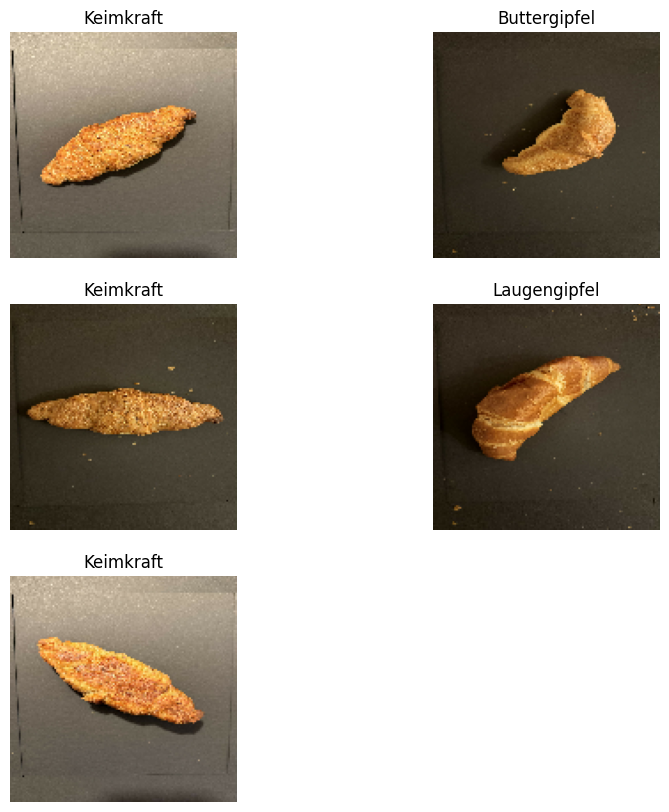

In [434]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 2, i + 1)
        im = images[i].numpy().astype("uint8")
        plt.imshow(im)
        plt.title(class_names[labels[i]])
        plt.axis("off")

Die folgende Zelle versucht, die Hardware gut auszulasten. Es gäbe [viel dazu zu sagen](https://www.tensorflow.org/guide/data_performance), aber sagen wir einfach, dass die Daten für einen raschen Zugriff vorbereitet werden:

In [435]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Nun definieren wir unser Modell! Hier können Sie Schichten von Neuronalen Netzen hinzufügen, die Aktivierungsfunktionen verändern und vieles mehr. Wichtig ist, dass `num_classes` stimmt, die Anzahl der Klassen und gleichzeitig die Anzahl Neuronen in der letzten (Ausgabe-)Schicht. Und natürlich die Grösse des Eingabebildes, `image_size`. 

In [ ]:
#functional API (https://keras.io/guides/functional_api/):
num_classes = len(class_names)
color_image_size=(*image_size,3)
def make_model():
    img_inputs = tf.keras.Input(shape=color_image_size,name='Eingabe')
    
    x = layers.Rescaling(1./255, input_shape=color_image_size)(img_inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.5)(x)
    x = layers.Conv2D(filter_amount[0], filter_size[0], padding='same', activation='relu')(x) #relu, sigmoid, tanh, softmax, linear, softplus, elu, selu, gelu, swish
    x = layers.MaxPooling2D()(x)# Reduziert Bildgrösse, hebt wichtigste Merkmale hervor
    x = layers.Conv2D(filter_amount[1], filter_size[1], padding='same', activation='relu')(x) 
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(filter_amount[2], filter_size[2], padding='same', activation='relu')(x) 
    x = layers.MaxPooling2D()(x)
    # x = layers.Conv2D(filter_amount[3], filter_size[3], padding='same', activation='relu')(x) 
    # x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dense, activation='relu')(x) 
    # x = layers.Dense(dense[1], activation='relu')(x) 
    outputs = layers.Dense(num_classes,name='Ausgabe',activation='softmax')(x)
    
    model = tf.keras.Model(inputs=img_inputs,outputs=outputs,name='Gipfellisucher') #Geben Sie Ihrem Modell doch einen hübschen, wiedererkennbaren Namen!
    return model 

model = make_model()

model.summary()

/Users/remofankhauser/Github/MSc_WI_DSCI/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Gipfellisucher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Eingabe (InputLayer)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_15 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_15 (RandomFlip)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_15              │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ausgabe (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,419 (4.09 MB)

 Trainable params: 1,072,419 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

Kompilieren des Modells heisst, dass der Gradientenabstieg und das Lernverfahren spezifiziert werden, und der low-level Code vorbereitet wird, welcher dann später die Hauptarbeit leistet. 

In [437]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Es ist immer gut zu verstehen, was während des Trainings passiert- und allenfalls im richtigen Moment zu reagieren. Tensorboard ist eine Web-Applikation, mit der Sie den Trainingsfortschritt verfolgen können. EarlyStopping ist ein Callback, der genau das tut: Er unterbricht das Training, sobald sich die gemonitorte Grösse (hier die Validierungsgenauigkeit) nicht mehr verbessert.

In [438]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100) #patience = 0? patience = 40? patience=200? 

Und...**LOS GEHT'S!** Je nach Grösse des Trainingsdatensatzes kann die nächste Zeile länger dauern. Die Anzahl Epochen kann auch limitiert werden. Stellen Sie sie vorerst so ein, dass Sie sich das Warten *leisten* können. Ev. ist es besser, vorerst mal ein sehr schlechtes Modell zu erzeugen- einfach um zu sehen, ob der Rest des Codes auch wirklich funktioniert.

In [439]:
epochs=10000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_callback]
)

Epoch 1/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.2793 - loss: 1.1229 - val_accuracy: 0.4074 - val_loss: 1.0479
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3514 - loss: 1.0990 - val_accuracy: 0.4444 - val_loss: 1.0546
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3333 - loss: 1.0838 - val_accuracy: 0.4815 - val_loss: 1.0199
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3784 - loss: 1.0759 - val_accuracy: 0.4815 - val_loss: 1.0428
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4775 - loss: 1.0588 - val_accuracy: 0.4444 - val_loss: 0.9754
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3604 - loss: 1.0615 - val_accuracy: 0.4815 - val_loss: 1.0331
Epoch 7/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5135 - loss: 1.0371 - val_accuracy: 0.5185 - val_loss: 0.9790
Epoch 8/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3964 - loss: 1.0105 - val_accuracy: 0

Das Modell hat hier (hoffentlich) fertig trainiert, und keinen Fehler produziert (möglich wären z.B. OutofMemory-Fehler o.ä.). Überprüfen Sie das! Denn nur bei Erfolgreichem Training lohnt es sich nun, die Validierungsgenauigkeit angeben zu lassen.

In [440]:
loss, metrics = model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0114


In [441]:
loss, metrics ,history.history.keys()

(0.011398764327168465,
 1.0,
 dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss']))

Das `history`-Objekt ist interessant, um zu sehen, wie der Trainingsverlauf war (wenn Sie das nicht schon auf Tensorboard gesehen haben.

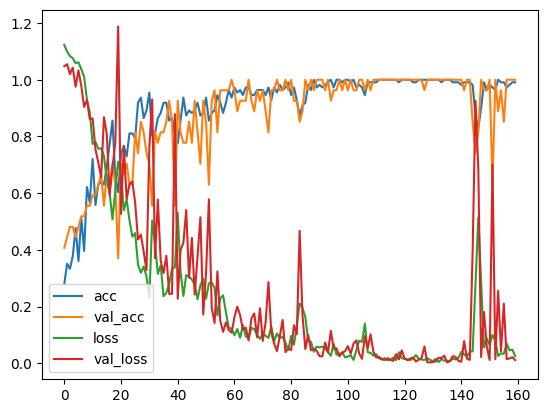

In [442]:
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
#plt.savefig('Trainingskurven.png')

Es lohnt sich, die Zeile

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20)

mal auf 

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=200)

o.ä. zu setzen, und ab der Zelle welche die Modelldefinition enthält (mit `model = keras.Model(...)`) den Code nochmals auszuführen (das Modell enthält die aktuellen Gewichte und trainiert bei erneutem Ausführen der `.fit`-Methode das bisherige Modell weiter, anstatt wieder neu bei zufällig initialisierten Gewichten zu beginnen!). Das Modell wird dann deutlich länger trainiert.

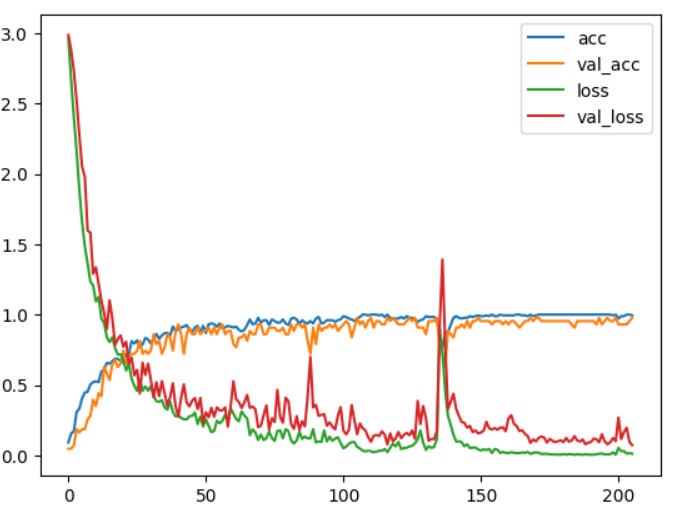

Beachten Sie, wie die Validierungsgenauigkeit schon lange stagniert, der Validierungsloss, d.h. der Wert der Verlustfunktion ausgewertet auf dem Validierungsdatensatz, seit etwa der 40. Epoche nur noch zunimmt. Der Validierungsdatensatz ist hier zu klein, um mehr sagen zu können, aber auch die Validierungsgenauigkeit scheint nach etwa der 40. Epoche abzunehmen! Es ist daher Wohl sinnvoll, dieses Modell auf diesem Datensatz nur 40 Epochen lang zu trainieren.

Dazu können Sie also nochmals das Modell erstellen, die Anzahl Epochen auf 40 setzen und Ihr finales Modell trainieren.

### Modell eine vorgegebene Anzahl Epochen lang trainieren

In [443]:
# vorgegebene_Anzahl_Epochen = 100 # Hier den Wert gemäss dem obigen Plot anpassen!
# final_model = make_model() # Die bisherigen Gewichte sind damit zurückgesetzt, d.h. es wird nicht weitertrainiert, sondern nochmals ganz von vorne.
# final_model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#              metrics=['accuracy'])

# final_history = final_model.fit(
#  train_ds,
#  validation_data=val_ds,
#  epochs=vorgegebene_Anzahl_Epochen
# )

In [444]:
# plt.plot(final_history.history['accuracy'],label='acc')
# plt.plot(final_history.history['val_accuracy'],label='val_acc')
# plt.plot(final_history.history['loss'],label='loss')
# plt.plot(final_history.history['val_loss'],label='val_loss')
# plt.legend();

## Evaluation mit Validierungsdatensatz
Eine angemessene Evaluation der Güte des Modells sollte auf dem Validierungsdatensatz passieren. Der Beispiel-Datensatz ist allerdings sehr klein! Entsprechend sind hier keine besonders robusten Resultate zu erwarten. 

In [445]:
#images = np.asarray(list(val_ds2.map(lambda x, y: x)))
y = np.asarray(list(val_ds.unbatch().map(lambda x, y: y)))
y.shape

(27,)

In [446]:
yhat = model.predict(val_ds)# yhat = final_model.predict(val_ds)
yhatnum = yhat.argmax(axis=1)
yhatnum

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([2, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2,
       2, 2, 2, 0, 0])

In [447]:
#skplt.metrics.plot_confusion_matrix?

In [448]:
y_str = np.array(class_names)[y]
yhat_str = np.array(class_names)[yhatnum]

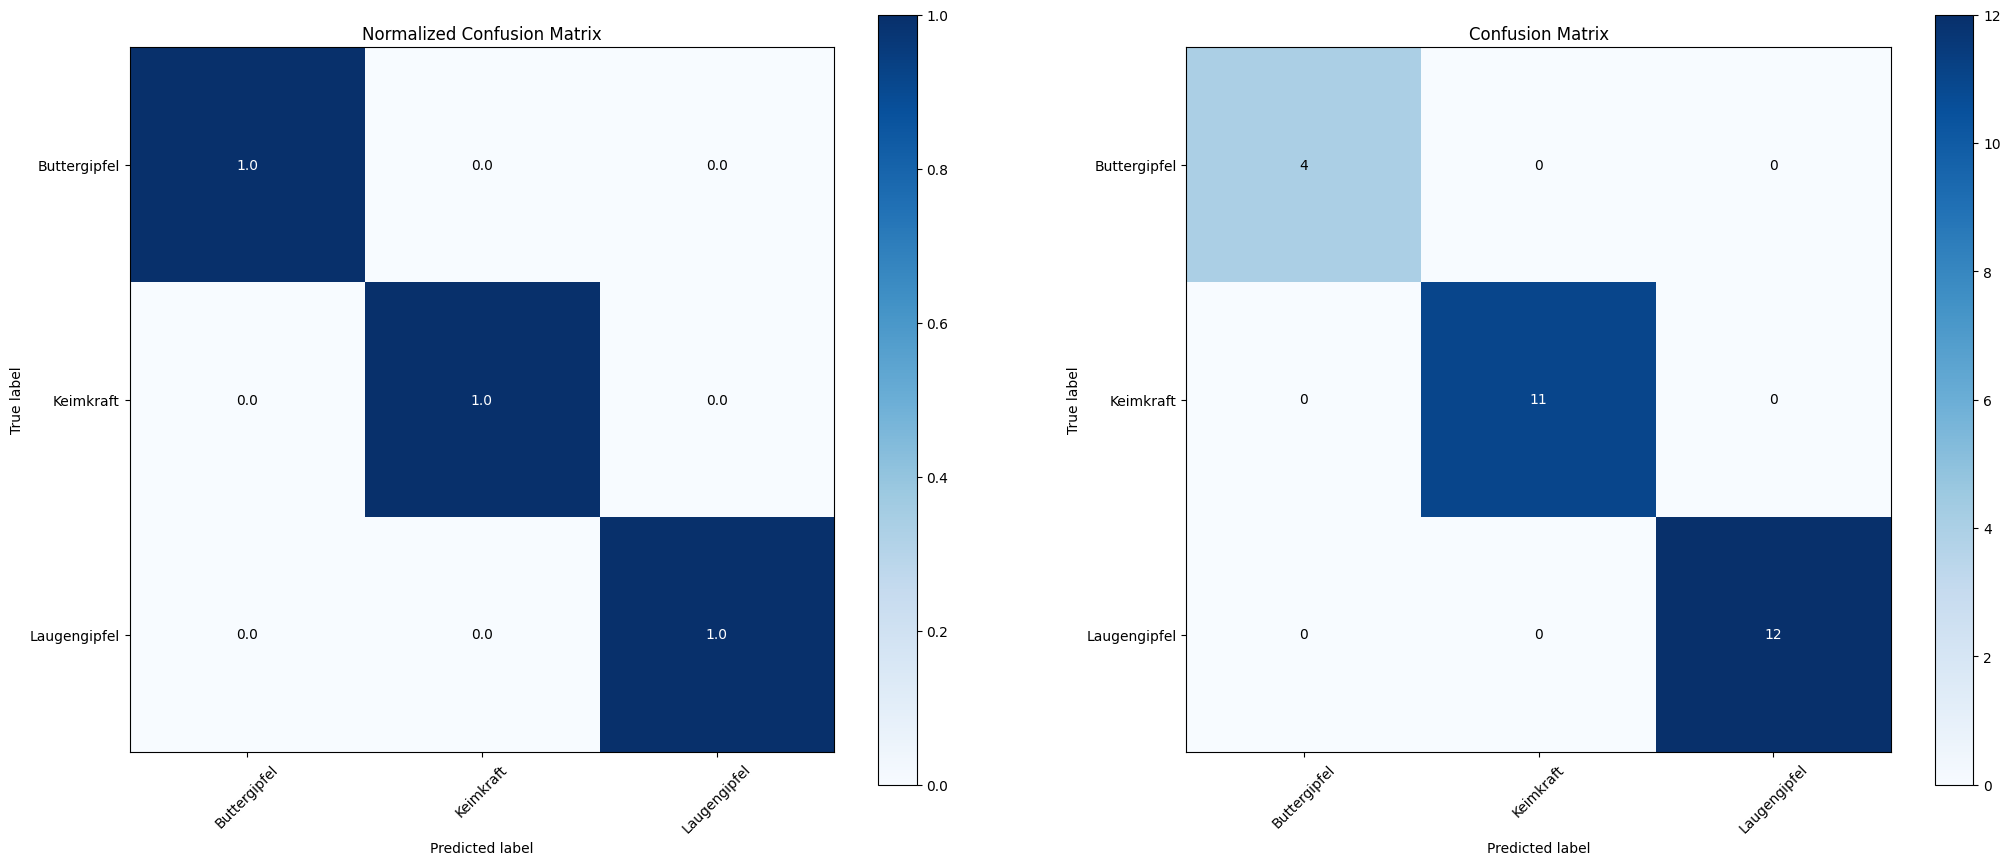

In [449]:
fig,axlist = plt.subplots(1,2,figsize=(25,10));
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=True,ax=axlist[0]);axlist[0].tick_params(axis='x', rotation=45)
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=False,ax=axlist[1]);axlist[1].tick_params(axis='x', rotation=45)

# Abspeichern des Modells als Keras-Modell


In [450]:
Keras_Dateiname = f'model_{Datensatzname}.keras'
voller_Keras_Dateiname = str(Path(model_output_path)/Keras_Dateiname)
model.save(voller_Keras_Dateiname) # final_model.save(voller_Keras_Dateiname)
print(f'Keras-Modell nach {voller_Keras_Dateiname} abgespeichert.')

Keras-Modell nach Model/model_Gipfeli.keras abgespeichert.


So kann man das Modell wieder laden:

    model = tf.keras.models.load_model(voller_Keras_Dateiname)

(Es gibt aber verwirrend viele Formate- .h5, .keras, etc. Siehe auch [hier](https://www.tensorflow.org/tutorials/keras/save_and_load). Wir möchten uns an das .h5-Format halten.)  
Der folgende Befehl kann zur Vorhersage genutzt werden:

In [451]:
loaded_model = tf.keras.models.load_model(voller_Keras_Dateiname)

In [452]:
loaded_model.predict(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[4.06717777e-15, 1.24761916e-03, 9.98752415e-01],
       [9.99522209e-01, 4.77850932e-04, 1.42448303e-10],
       [1.35394557e-14, 9.66699794e-03, 9.90333021e-01],
       [7.70563671e-24, 6.75109625e-02, 9.32489038e-01],
       [1.28155045e-23, 1.42023573e-05, 9.99985814e-01],
       [9.37731298e-20, 2.62940070e-03, 9.97370601e-01],
       [9.96943831e-01, 3.05616739e-03, 3.17307874e-10],
       [3.33674754e-10, 9.99904454e-01, 9.56099248e-05],
       [2.50120240e-04, 9.99748945e-01, 9.55204996e-07],
       [2.32908496e-06, 9.99996543e-01, 1.11898089e-06],
       [5.00638125e-05, 9.98118281e-01, 1.83164689e-03],
       [1.42467497e-05, 9.99985218e-01, 4.47516612e-07],
       [1.95514891e-18, 1.30712474e-03, 9.98692930e-01],
       [1.59287361e-09, 9.94052112e-01, 5.94787113e-03],
       [7.56052998e-11, 9.95506346e-01, 4.49372968e-03],
       [2.08444651e-20, 8.27821277e-05, 9.99917328e-01],
       [2.80914946e-07, 9.99987364e-01, 1.24195567e-05],
       [2.78861073e-10, 5.71748

Das wär's! Nach dem Speichern ("Save Version" in Kaggle) kann das Modell heruntergeladen werden. Vergessen Sie nicht, welche Bilder Trainingsbilder, und welche Testbilder sind. Ein Modell, das overfittet, wird auf den Trainingsdaten eine viel bessere Performanz zeigen, als auf den Testbildern. Nur jene der Testbilder darf rapportiert werden, denn nur so gut ist die Verallgemeinerungsleistung des neuronalen Netzes. Wir speichern daher noch eine Excel-Datei mit den entsprechenden Zuordnungen ab:

In [453]:
ser = pd.Series(train_or_test)
ser

Laugengipfel_low_light_34.jpg        train
Laugengipfel_low_light_20.jpg        train
Keimkraft_Gipfel_light_15.jpg        train
Laugengipfel_light_19.jpg            train
Keimkraft_Gipfel_light_01.jpg        train
                                     ...  
Keimkraft_Gipfel_light_30.jpg         test
Keimkraft_Gipfel_low_light_41.jpg     test
Keimkraft_Gipfel_light_18.jpg         test
Laugengipfel_light_14.jpg             test
Laugengipfel_low_light_11.jpg         test
Length: 174, dtype: object

In [454]:
ser.to_excel('train_test_split.xlsx')
ser.value_counts()

train    120
test      54
Name: count, dtype: int64

Weiter geht's mit dem Notebook [Giraffenpuzzle-Evaluation](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-evaluation). Dort wollen wir die Performanz eines Modells evaluieren.

### Export eines Report für jeden Versuch

In [455]:
# import io
# from datetime import datetime
# import matplotlib.pyplot as plt
# import scikitplot as skplt
# from reportlab.lib.pagesizes import A4
# from reportlab.platypus import SimpleDocTemplate, Spacer, Image as RLImage, Table, TableStyle
# from reportlab.lib import colors
# from reportlab.lib.styles import getSampleStyleSheet

# # =====================================================
# # 1. Ordner vorbereiten und automatisches Hochzählen
# # =====================================================
# report_dir = "reports"
# os.makedirs(report_dir, exist_ok=True)

# base_name = "Experiment"
# existing = [f for f in os.listdir(report_dir) if f.startswith(base_name) and f.endswith(".pdf")]
# if existing:
#     nums = [int(f[len(base_name):-4]) for f in existing if f[len(base_name):-4].isdigit()]
#     next_num = max(nums) + 1 if nums else 1
# else:
#     next_num = 1
# experiment_name = f"{base_name}{next_num}"

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# report_path = os.path.join(report_dir, f"{experiment_name}_{timestamp}.pdf")

# # =====================================================
# # 2. Trainingskurven-Plot
# # =====================================================
# fig_train, ax = plt.subplots(figsize=(10, 4))
# ax.plot(history.history['accuracy'], label='acc')
# ax.plot(history.history['val_accuracy'], label='val_acc')
# ax.plot(history.history['loss'], label='loss')
# ax.plot(history.history['val_loss'], label='val_loss')
# ax.legend()
# ax.set_title("Training Accuracy & Loss")
# ax.set_xlabel("Epoche")
# ax.set_ylabel("Wert")
# plt.tight_layout()

# # =====================================================
# # 3. Confusion-Matrix-Plot
# # =====================================================
# fig_conf, axlist = plt.subplots(1, 2, figsize=(25, 10))
# skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=True, ax=axlist[0])
# axlist[0].set_title("Normalized Confusion Matrix")
# axlist[0].tick_params(axis="x", rotation=45)

# skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=False, ax=axlist[1])
# axlist[1].set_title("Raw Confusion Matrix")
# axlist[1].tick_params(axis="x", rotation=45)
# plt.tight_layout()

# # =====================================================
# # 4. Matplotlib-Figur → ReportLab-Image
# # =====================================================
# def fig_to_rlimage(fig, width=480, height=240):
#     buf = io.BytesIO()
#     fig.savefig(buf, format='png', bbox_inches='tight')
#     buf.seek(0)
#     return RLImage(buf, width=width, height=height)

# # =====================================================
# # 5. Variablen und letzte Werte
# # =====================================================
# last_acc = history.history['accuracy'][-1]
# last_val_acc = history.history['val_accuracy'][-1]
# last_loss = history.history['loss'][-1]
# last_val_loss = history.history['val_loss'][-1]

# # Parameter
# params = {
#     k: v for k, v in globals().items()
#     if k in [
#         "training_size",
#         "validation_size",
#         "batch_size",
#         "image_size",
#         "filter_size",
#         "filter_amount",
#         "dense"
#     ]
# }

# # Metriken
# metrics = {
#     "accuracy (train)": round(last_acc, 4),
#     "accuracy (val)": round(last_val_acc, 4),
#     "loss (train)": round(last_loss, 4),
#     "loss (val)": round(last_val_loss, 4)
# }

# # =====================================================
# # 6. PDF Aufbau
# # =====================================================
# styles = getSampleStyleSheet()
# doc = SimpleDocTemplate(
#     report_path,
#     pagesize=A4,
#     topMargin=40,
#     bottomMargin=40,
#     leftMargin=40,
#     rightMargin=30
# )
# elements = []

# # Zwei Tabellen nebeneinander
# if params and metrics:
#     table_data_params = [["Parameter", "Wert"]] + [[k, str(v)] for k, v in params.items()]
#     table_data_metrics = [["Metrik", "Wert"]] + [[k, str(v)] for k, v in metrics.items()]

#     table_params = Table(table_data_params)
#     table_metrics = Table(table_data_metrics)

#     for t in [table_params, table_metrics]:
#         t.setStyle(TableStyle([
#             ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
#             ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
#             ("GRID", (0, 0), (-1, -1), 0.5, colors.black),
#             ("BOTTOMPADDING", (0, 0), (-1, -1), 6),
#             ("TOPPADDING", (0, 0), (-1, -1), 6),
#         ]))

#     # Beide Tabellen in einer Zeile platzieren
#     combined_table = Table([[table_params, table_metrics]], hAlign="LEFT", colWidths=[250, 200])
#     elements.append(combined_table)
#     elements.append(Spacer(1, 25))

# # Plots einfügen
# elements.append(fig_to_rlimage(fig_train, width=500, height=230))
# elements.append(Spacer(1, 30))
# elements.append(fig_to_rlimage(fig_conf, width=500, height=250))

# # PDF erzeugen
# doc.build(elements)